In [1]:
import pickle
import os
import numpy as np
import pandas as pd
import music21 as m21
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from datetime import datetime
import gc

In [2]:
def chooseOneGPU(chosenGPU):
    '''
    Limits tensorflow to one GPU
    Inputs:
        chosenGPU: the ID of the chosen GPU
    Outputs:
        none
    '''
    # Limit to ONE GPU
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        # Restrict TensorFlow to only use ONE GPU
        try:
            tf.config.experimental.set_visible_devices(gpus[chosenGPU], 'GPU')
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
        except RuntimeError as e:
            # Visible devices must be set before GPUs have been initialized
            print(e)

In [3]:
if (str(input("Do You Want to use one GPU? y/[n]: ")).startswith("y")):
    print(tf.config.experimental.list_physical_devices('GPU'))
    chooseOneGPU(int(input("Choose the ID of the GPU you want to use: ")))

Do You Want to use one GPU? y/[n]: n


In [4]:
def openScore (fileName, folder = 'databases/nesmdb24_seprsco/train/'):
    with open(folder+fileName, 'rb') as f:
        rate, nsamps, seprsco = pickle.load(f)
    return rate, nsamps, seprsco

In [5]:
def openFolder (folder):
    i = 0
    df = pd.DataFrame(columns = ("score", "rate", "nsamps", "fileName", "notes"))
    for file in os.listdir(folder):
        rate, nsamps, seprsco = openScore(file, folder)
        notes, dump = seprsco.shape
        df.loc[i] = [seprsco, rate, nsamps, file, notes]
        i+=1
    df['rate'] = pd.to_numeric(df['rate'])
    df['nsamps'] = pd.to_numeric(df['nsamps'])
    df['notes'] = pd.to_numeric(df['notes'])
    return df

In [6]:
def openFolderSplit (folder, splitOn = 100):
    i = 0
    df = pd.DataFrame(columns = ("score", "rate", "origNsamps", "fileName"))
    for file in os.listdir(folder):
        rate, nsamps, seprsco = openScore(file, folder)
        notes, dump = seprsco.shape
        j = 0;
        while (notes > (j+1)*splitOn):
            #should split on number of notes 100
            #print ("added:", file, "notes:", str(j*splitOn), "-", str((j+1)*splitOn))
            df.loc[i] = [seprsco[j*splitOn:(j+1)*splitOn], rate, nsamps, file+str(j)]
            i+=1
            j+=1
    df['rate'] = pd.to_numeric(df['rate'])
    df['origNsamps'] = pd.to_numeric(df['origNsamps'])
    return df

In [7]:
def openFolderSplit2 (folder, splitOn = 100, normalize=True):
    channelLengths = [108, 108, 108, 16]
    items = []
    for file in os.listdir(folder):
        rate, nsamps, seprsco = openScore(file, folder)
        if (normalize):
            seprsco = seprsco.astype(float)
            for i in range(4):
                seprsco[:,i] =(seprsco[:, i] - channelLengths[i]/2)/(channelLengths[i]/2)
        j = 0;
        while (len(seprsco) > (j+1)*splitOn):
            #should split on number of notes 100
            items.append(seprsco[j*splitOn:(j+1)*splitOn])
            #print ("added:", file, "notes:", str(j*splitOn), "-", str((j+1)*splitOn-1))
            j+=1
    return np.array(items)

In [8]:
items = openFolderSplit2('databases/nesmdb24_seprsco/train/', 1024)
items.shape

(1700, 1024, 4)

In [9]:
np.savetxt("foo.csv", items[0], delimiter=",")

In [10]:
itemsTest = openFolderSplit2('databases/nesmdb24_seprsco/test/', 1024)
itemsTest.shape

(83, 1024, 4)

In [11]:
itemsVal = openFolderSplit2('databases/nesmdb24_seprsco/valid/', 1024)
itemsVal.shape

(122, 1024, 4)

In [12]:
itemsAll = np.concatenate([items, itemsTest, itemsVal])

In [13]:
itemsAll.shape

(1905, 1024, 4)

In [19]:
class NESGAN:
    
    mus_length = 1024
    
    def __init__(self, rows):
        self.seq_length = rows
        self.seq_shape = (self.seq_length, 4)
        self.latent_dim = 1024
        self.disc_loss = []
        self.gen_loss = []
        
        optimizer = tf.keras.optimizers.Adam(0.0002, 0.5)
        
        self.discriminator = self.createDiscriminator()
        self.discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        
        self.generator = self.createGenerator()
        
        z = tf.keras.layers.Input(shape=(self.latent_dim,))
        generated_seq = self.generator(z)
        
        self.discriminator.trainable = False
        
        validity = self.discriminator(generated_seq)
        
        self.combined = tf.keras.models.Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
    
    def createDiscriminator(self):
        model = tf.keras.models.Sequential([
            tf.keras.layers.LSTM(512, input_shape = self.seq_shape, return_sequences=True),
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512)),
            tf.keras.layers.Dense(512),
            tf.keras.layers.LeakyReLU(alpha=0.2),
            tf.keras.layers.Dense(256),
            tf.keras.layers.LeakyReLU(alpha=0.2),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])
        model.summary()
        seq = tf.keras.layers.Input(self.seq_shape)
        validity = model(seq)
        
        return tf.keras.models.Model(seq, validity)
    
    def createGenerator(self):
        model = tf.keras.models.Sequential([
            tf.keras.layers.Dense(256, input_dim = self.latent_dim),
            tf.keras.layers.LeakyReLU(alpha=0.2),
            tf.keras.layers.BatchNormalization(momentum=0.8),
            tf.keras.layers.Dense(512),
            tf.keras.layers.LeakyReLU(alpha=0.2),
            tf.keras.layers.BatchNormalization(momentum=0.8),
            tf.keras.layers.Dense(1024),
            tf.keras.layers.LeakyReLU(alpha=0.2),
            tf.keras.layers.BatchNormalization(momentum=0.8),
            tf.keras.layers.Dense(np.prod(self.seq_shape), activation='tanh'),
            tf.keras.layers.Reshape(self.seq_shape)
        ])
        
        model.summary()
        
        noise = tf.keras.layers.Input(shape=(self.latent_dim,))
        seq=model(noise)
        
        return tf.keras.models.Model(noise, seq)
    
    def train(self, x_train, epochs, batch_size=128, sample_interval=50):
        
        real = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        
        for epoch in range(epochs):
            
            idx = np.random.randint(0, x_train.shape[0], batch_size)
            real_seqs = x_train[idx]
            
            noise = tf.random.normal((batch_size, self.latent_dim), 0, 1)
            
            gan_result = self.generator.predict(noise)
            gan_seqs =  np.array(gan_result)
            
            test_seqs = np.concatenate((real_seqs, gan_seqs))
            train_seqs = np.concatenate((real, fake))
            test_seqs, test_labels = shuffle(test_seqs, train_seqs)
            
            #d_loss_real = self.discriminator.train_on_batch(real_seqs, real)
            #d_loss_fake = self.discriminator.train_on_batch(gen_seqs, fake)
            #d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            d_loss = self.discriminator.train_on_batch(x=test_seqs, y=test_labels, sample_weight=None, class_weight=None, reset_metrics=True, return_dict=False)

            
            noise = tf.random.normal((batch_size, self.latent_dim), 0, 1)
            
            g_loss = self.combined.train_on_batch(noise, real)
            gc.collect()
            
            if (epoch % sample_interval == 0):
                print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
                self.disc_loss.append(d_loss[0])
                self.gen_loss.append(g_loss)
            
            
        #self.generate(notes)
        self.plot_loss()
    
    def generate(self, input_notes):
        
        noise = tf.random.normal((1, self.latent_dim), 0, 1)
        predictions = self.generator.predict(noise)
    
    def plot_loss(self):
        plt.plot(self.disc_loss, c='red')
        plt.plot(self.gen_loss, c='blue')
        plt.title("GAN Loss per Epoch")
        plt.legend(['Discriminator', 'Generator'])
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.savefig('GAN_Loss_per_Epoch_final.png', transparent=True)
        plt.show()
        
        
        
        

In [15]:
gan = NESGAN(rows=1024)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1024, 512)         1058816   
_________________________________________________________________
bidirectional (Bidirectional (None, 1024)              4198400   
_________________________________________________________________
dense (Dense)                (None, 512)               524800    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 2

In [16]:
now = datetime.now()

current_time = now.strftime("%H:%M:%S")
print("Current Time =", current_time)

Current Time = 00:30:15


In [17]:
gan.train(itemsAll, epochs=5000, batch_size=16, sample_interval=1)
gan.plot_loss()

0 [D loss: 0.697673, acc.: 53.12%] [G loss: 0.693123]
1 [D loss: 0.676003, acc.: 84.38%] [G loss: 0.692459]
2 [D loss: 0.660694, acc.: 87.50%] [G loss: 0.691679]
3 [D loss: 0.642413, acc.: 78.12%] [G loss: 0.692094]
4 [D loss: 0.597367, acc.: 90.62%] [G loss: 0.699203]
5 [D loss: 0.537841, acc.: 81.25%] [G loss: 0.706964]
6 [D loss: 0.417854, acc.: 90.62%] [G loss: 0.820418]
7 [D loss: 0.442161, acc.: 71.88%] [G loss: 0.860623]
8 [D loss: 0.415425, acc.: 84.38%] [G loss: 0.943589]
9 [D loss: 0.336719, acc.: 93.75%] [G loss: 1.310727]
10 [D loss: 0.368506, acc.: 87.50%] [G loss: 2.007803]
11 [D loss: 0.223839, acc.: 90.62%] [G loss: 3.513483]
12 [D loss: 0.666240, acc.: 87.50%] [G loss: 2.494036]
13 [D loss: 0.205269, acc.: 93.75%] [G loss: 2.654239]
14 [D loss: 0.283194, acc.: 90.62%] [G loss: 1.889552]
15 [D loss: 0.294738, acc.: 90.62%] [G loss: 1.711551]
16 [D loss: 0.165415, acc.: 96.88%] [G loss: 1.967011]
17 [D loss: 0.331348, acc.: 90.62%] [G loss: 2.101117]
18 [D loss: 0.309319

149 [D loss: 0.515403, acc.: 71.88%] [G loss: 0.915506]
150 [D loss: 0.445948, acc.: 78.12%] [G loss: 0.892071]
151 [D loss: 0.497211, acc.: 78.12%] [G loss: 1.213581]
152 [D loss: 0.582236, acc.: 56.25%] [G loss: 1.334044]
153 [D loss: 0.735120, acc.: 59.38%] [G loss: 0.988822]
154 [D loss: 0.422396, acc.: 90.62%] [G loss: 0.949464]
155 [D loss: 0.610589, acc.: 56.25%] [G loss: 0.972871]
156 [D loss: 0.614450, acc.: 71.88%] [G loss: 0.981733]
157 [D loss: 0.568819, acc.: 68.75%] [G loss: 1.172282]
158 [D loss: 0.634019, acc.: 59.38%] [G loss: 0.942464]
159 [D loss: 0.543846, acc.: 71.88%] [G loss: 1.154927]
160 [D loss: 0.629953, acc.: 59.38%] [G loss: 1.243167]
161 [D loss: 0.609126, acc.: 71.88%] [G loss: 0.971157]
162 [D loss: 0.568449, acc.: 68.75%] [G loss: 0.748882]
163 [D loss: 0.693650, acc.: 62.50%] [G loss: 1.322459]
164 [D loss: 0.644645, acc.: 53.12%] [G loss: 1.440687]
165 [D loss: 0.502056, acc.: 84.38%] [G loss: 1.356371]
166 [D loss: 0.591529, acc.: 68.75%] [G loss: 1.

296 [D loss: 0.242369, acc.: 93.75%] [G loss: 2.567585]
297 [D loss: 0.097618, acc.: 100.00%] [G loss: 2.741982]
298 [D loss: 0.050424, acc.: 100.00%] [G loss: 3.120669]
299 [D loss: 0.453607, acc.: 87.50%] [G loss: 2.966349]
300 [D loss: 0.231973, acc.: 93.75%] [G loss: 2.021959]
301 [D loss: 0.185748, acc.: 93.75%] [G loss: 1.862429]
302 [D loss: 0.312351, acc.: 90.62%] [G loss: 2.305353]
303 [D loss: 0.239182, acc.: 93.75%] [G loss: 2.800140]
304 [D loss: 0.205248, acc.: 93.75%] [G loss: 2.648667]
305 [D loss: 0.057793, acc.: 100.00%] [G loss: 3.076627]
306 [D loss: 0.357496, acc.: 90.62%] [G loss: 2.281300]
307 [D loss: 0.414267, acc.: 87.50%] [G loss: 1.988019]
308 [D loss: 0.168757, acc.: 96.88%] [G loss: 2.450374]
309 [D loss: 0.271295, acc.: 90.62%] [G loss: 1.610596]
310 [D loss: 0.712067, acc.: 75.00%] [G loss: 1.505506]
311 [D loss: 0.267476, acc.: 96.88%] [G loss: 2.411094]
312 [D loss: 0.167758, acc.: 96.88%] [G loss: 2.597949]
313 [D loss: 0.301080, acc.: 90.62%] [G loss:

443 [D loss: 0.342385, acc.: 90.62%] [G loss: 1.683211]
444 [D loss: 0.279418, acc.: 93.75%] [G loss: 1.849625]
445 [D loss: 0.313337, acc.: 90.62%] [G loss: 2.434484]
446 [D loss: 0.271134, acc.: 93.75%] [G loss: 2.292803]
447 [D loss: 0.576972, acc.: 81.25%] [G loss: 1.808872]
448 [D loss: 0.467485, acc.: 84.38%] [G loss: 1.248097]
449 [D loss: 0.735001, acc.: 68.75%] [G loss: 1.198127]
450 [D loss: 0.491344, acc.: 81.25%] [G loss: 1.356890]
451 [D loss: 0.490979, acc.: 81.25%] [G loss: 1.523731]
452 [D loss: 0.420808, acc.: 87.50%] [G loss: 1.944122]
453 [D loss: 0.257287, acc.: 96.88%] [G loss: 1.998051]
454 [D loss: 0.278028, acc.: 93.75%] [G loss: 2.805051]
455 [D loss: 0.673458, acc.: 78.12%] [G loss: 1.432185]
456 [D loss: 0.241134, acc.: 93.75%] [G loss: 1.447840]
457 [D loss: 0.271624, acc.: 93.75%] [G loss: 1.574759]
458 [D loss: 0.230664, acc.: 93.75%] [G loss: 1.906131]
459 [D loss: 0.336317, acc.: 90.62%] [G loss: 2.264447]
460 [D loss: 0.255052, acc.: 93.75%] [G loss: 2.

590 [D loss: 0.767973, acc.: 53.12%] [G loss: 0.802059]
591 [D loss: 0.653039, acc.: 56.25%] [G loss: 0.765280]
592 [D loss: 0.743952, acc.: 40.62%] [G loss: 0.897695]
593 [D loss: 0.631658, acc.: 59.38%] [G loss: 0.912580]
594 [D loss: 0.663259, acc.: 59.38%] [G loss: 0.848342]
595 [D loss: 0.664433, acc.: 53.12%] [G loss: 0.831672]
596 [D loss: 0.698257, acc.: 53.12%] [G loss: 0.759614]
597 [D loss: 0.705188, acc.: 53.12%] [G loss: 0.828030]
598 [D loss: 0.620501, acc.: 53.12%] [G loss: 0.708865]
599 [D loss: 0.625247, acc.: 56.25%] [G loss: 0.847787]
600 [D loss: 0.611670, acc.: 75.00%] [G loss: 0.823925]
601 [D loss: 0.673775, acc.: 53.12%] [G loss: 0.777189]
602 [D loss: 0.684455, acc.: 40.62%] [G loss: 0.912985]
603 [D loss: 0.614426, acc.: 62.50%] [G loss: 0.793804]
604 [D loss: 0.606598, acc.: 81.25%] [G loss: 0.833258]
605 [D loss: 0.577753, acc.: 78.12%] [G loss: 0.837545]
606 [D loss: 0.646684, acc.: 65.62%] [G loss: 0.818262]
607 [D loss: 0.623056, acc.: 62.50%] [G loss: 0.

737 [D loss: 0.662474, acc.: 65.62%] [G loss: 0.804796]
738 [D loss: 0.644218, acc.: 71.88%] [G loss: 0.802555]
739 [D loss: 0.595321, acc.: 65.62%] [G loss: 0.716352]
740 [D loss: 0.577453, acc.: 78.12%] [G loss: 1.019582]
741 [D loss: 0.622776, acc.: 62.50%] [G loss: 0.800010]
742 [D loss: 0.542738, acc.: 68.75%] [G loss: 1.120642]
743 [D loss: 0.492269, acc.: 84.38%] [G loss: 0.781332]
744 [D loss: 0.737907, acc.: 46.88%] [G loss: 1.152373]
745 [D loss: 0.663106, acc.: 68.75%] [G loss: 0.925532]
746 [D loss: 0.631643, acc.: 59.38%] [G loss: 0.884334]
747 [D loss: 0.682208, acc.: 56.25%] [G loss: 1.044279]
748 [D loss: 0.499496, acc.: 84.38%] [G loss: 1.048291]
749 [D loss: 0.614453, acc.: 62.50%] [G loss: 1.150727]
750 [D loss: 0.540062, acc.: 75.00%] [G loss: 0.415496]
751 [D loss: 0.672389, acc.: 75.00%] [G loss: 1.005961]
752 [D loss: 0.586920, acc.: 68.75%] [G loss: 0.974603]
753 [D loss: 0.555100, acc.: 71.88%] [G loss: 1.009085]
754 [D loss: 0.536688, acc.: 71.88%] [G loss: 0.

884 [D loss: 0.643829, acc.: 75.00%] [G loss: 0.951891]
885 [D loss: 0.613105, acc.: 62.50%] [G loss: 0.814631]
886 [D loss: 0.583170, acc.: 59.38%] [G loss: 0.935629]
887 [D loss: 0.485099, acc.: 75.00%] [G loss: 0.992439]
888 [D loss: 0.595948, acc.: 71.88%] [G loss: 1.043846]
889 [D loss: 0.600865, acc.: 65.62%] [G loss: 1.101018]
890 [D loss: 0.630450, acc.: 59.38%] [G loss: 0.640580]
891 [D loss: 0.609537, acc.: 62.50%] [G loss: 0.706611]
892 [D loss: 0.591302, acc.: 68.75%] [G loss: 0.720403]
893 [D loss: 0.608689, acc.: 65.62%] [G loss: 0.867102]
894 [D loss: 0.661819, acc.: 62.50%] [G loss: 0.769366]
895 [D loss: 0.626431, acc.: 59.38%] [G loss: 0.918489]
896 [D loss: 0.590815, acc.: 68.75%] [G loss: 0.911519]
897 [D loss: 0.560045, acc.: 75.00%] [G loss: 0.886553]
898 [D loss: 0.666158, acc.: 75.00%] [G loss: 0.933834]
899 [D loss: 0.681810, acc.: 59.38%] [G loss: 0.717251]
900 [D loss: 0.603842, acc.: 71.88%] [G loss: 0.565105]
901 [D loss: 0.615299, acc.: 65.62%] [G loss: 0.

1030 [D loss: 0.575043, acc.: 71.88%] [G loss: 0.733697]
1031 [D loss: 0.704556, acc.: 56.25%] [G loss: 0.857614]
1032 [D loss: 0.659546, acc.: 53.12%] [G loss: 0.605523]
1033 [D loss: 0.610828, acc.: 75.00%] [G loss: 0.523878]
1034 [D loss: 0.578138, acc.: 71.88%] [G loss: 0.623340]
1035 [D loss: 0.789011, acc.: 56.25%] [G loss: 0.860220]
1036 [D loss: 0.717341, acc.: 53.12%] [G loss: 0.860384]
1037 [D loss: 0.547629, acc.: 78.12%] [G loss: 0.866403]
1038 [D loss: 0.585615, acc.: 68.75%] [G loss: 0.833403]
1039 [D loss: 0.591081, acc.: 75.00%] [G loss: 0.790366]
1040 [D loss: 0.582482, acc.: 68.75%] [G loss: 1.091233]
1041 [D loss: 0.554951, acc.: 68.75%] [G loss: 1.558524]
1042 [D loss: 0.600246, acc.: 71.88%] [G loss: 0.897293]
1043 [D loss: 0.717955, acc.: 56.25%] [G loss: 1.130603]
1044 [D loss: 0.503092, acc.: 84.38%] [G loss: 0.700921]
1045 [D loss: 0.496915, acc.: 75.00%] [G loss: 1.162071]
1046 [D loss: 0.624608, acc.: 56.25%] [G loss: 1.400904]
1047 [D loss: 0.598086, acc.: 5

1174 [D loss: 0.706078, acc.: 56.25%] [G loss: 1.016191]
1175 [D loss: 0.527263, acc.: 84.38%] [G loss: 0.891817]
1176 [D loss: 0.554353, acc.: 71.88%] [G loss: 0.921593]
1177 [D loss: 0.566705, acc.: 71.88%] [G loss: 1.094532]
1178 [D loss: 0.599761, acc.: 71.88%] [G loss: 1.142591]
1179 [D loss: 0.682844, acc.: 62.50%] [G loss: 1.234087]
1180 [D loss: 0.499374, acc.: 81.25%] [G loss: 0.964895]
1181 [D loss: 0.660583, acc.: 62.50%] [G loss: 0.921637]
1182 [D loss: 0.547049, acc.: 68.75%] [G loss: 0.935987]
1183 [D loss: 0.517530, acc.: 78.12%] [G loss: 0.987906]
1184 [D loss: 0.543750, acc.: 78.12%] [G loss: 0.929752]
1185 [D loss: 0.608101, acc.: 75.00%] [G loss: 0.728469]
1186 [D loss: 0.627588, acc.: 59.38%] [G loss: 1.194318]
1187 [D loss: 0.665955, acc.: 56.25%] [G loss: 1.235965]
1188 [D loss: 0.638323, acc.: 56.25%] [G loss: 0.880111]
1189 [D loss: 0.617823, acc.: 71.88%] [G loss: 0.974240]
1190 [D loss: 0.632138, acc.: 62.50%] [G loss: 0.876562]
1191 [D loss: 0.629087, acc.: 6

1318 [D loss: 0.582947, acc.: 75.00%] [G loss: 0.854060]
1319 [D loss: 0.608843, acc.: 65.62%] [G loss: 0.823941]
1320 [D loss: 0.591733, acc.: 59.38%] [G loss: 1.013032]
1321 [D loss: 0.652140, acc.: 62.50%] [G loss: 0.965597]
1322 [D loss: 0.666095, acc.: 65.62%] [G loss: 0.733469]
1323 [D loss: 0.556940, acc.: 65.62%] [G loss: 0.789941]
1324 [D loss: 0.678753, acc.: 59.38%] [G loss: 1.077035]
1325 [D loss: 0.651592, acc.: 62.50%] [G loss: 0.840753]
1326 [D loss: 0.578466, acc.: 71.88%] [G loss: 0.844104]
1327 [D loss: 0.639314, acc.: 65.62%] [G loss: 0.815337]
1328 [D loss: 0.611547, acc.: 62.50%] [G loss: 0.853778]
1329 [D loss: 0.611074, acc.: 65.62%] [G loss: 0.747890]
1330 [D loss: 0.616637, acc.: 59.38%] [G loss: 0.877792]
1331 [D loss: 0.612932, acc.: 68.75%] [G loss: 0.987508]
1332 [D loss: 0.599594, acc.: 68.75%] [G loss: 0.841235]
1333 [D loss: 0.551128, acc.: 71.88%] [G loss: 0.788582]
1334 [D loss: 0.573876, acc.: 81.25%] [G loss: 0.828720]
1335 [D loss: 0.673074, acc.: 6

1462 [D loss: 0.676185, acc.: 46.88%] [G loss: 0.670026]
1463 [D loss: 0.629417, acc.: 75.00%] [G loss: 0.803242]
1464 [D loss: 0.638957, acc.: 62.50%] [G loss: 0.762600]
1465 [D loss: 0.597721, acc.: 62.50%] [G loss: 0.843774]
1466 [D loss: 0.624126, acc.: 65.62%] [G loss: 0.823495]
1467 [D loss: 0.668632, acc.: 56.25%] [G loss: 0.922976]
1468 [D loss: 0.683455, acc.: 56.25%] [G loss: 0.852206]
1469 [D loss: 0.587534, acc.: 71.88%] [G loss: 0.753594]
1470 [D loss: 0.668300, acc.: 50.00%] [G loss: 0.738766]
1471 [D loss: 0.647058, acc.: 50.00%] [G loss: 0.703607]
1472 [D loss: 0.750692, acc.: 59.38%] [G loss: 1.072247]
1473 [D loss: 0.655622, acc.: 59.38%] [G loss: 0.992602]
1474 [D loss: 0.663526, acc.: 53.12%] [G loss: 0.874679]
1475 [D loss: 0.595889, acc.: 65.62%] [G loss: 0.718373]
1476 [D loss: 0.707985, acc.: 56.25%] [G loss: 0.888261]
1477 [D loss: 0.620671, acc.: 68.75%] [G loss: 1.066410]
1478 [D loss: 0.633080, acc.: 59.38%] [G loss: 0.749261]
1479 [D loss: 0.628453, acc.: 5

1606 [D loss: 0.629135, acc.: 59.38%] [G loss: 1.084627]
1607 [D loss: 0.701887, acc.: 53.12%] [G loss: 0.792524]
1608 [D loss: 0.655790, acc.: 68.75%] [G loss: 0.467122]
1609 [D loss: 0.746827, acc.: 50.00%] [G loss: 0.960158]
1610 [D loss: 0.605209, acc.: 59.38%] [G loss: 1.039275]
1611 [D loss: 0.662538, acc.: 56.25%] [G loss: 0.700570]
1612 [D loss: 0.621495, acc.: 65.62%] [G loss: 0.498008]
1613 [D loss: 0.594129, acc.: 62.50%] [G loss: 0.593411]
1614 [D loss: 0.689720, acc.: 50.00%] [G loss: 0.950277]
1615 [D loss: 0.588788, acc.: 65.62%] [G loss: 0.915145]
1616 [D loss: 0.609156, acc.: 68.75%] [G loss: 0.661668]
1617 [D loss: 0.613199, acc.: 53.12%] [G loss: 0.700657]
1618 [D loss: 0.665062, acc.: 53.12%] [G loss: 0.801508]
1619 [D loss: 0.703053, acc.: 62.50%] [G loss: 0.786490]
1620 [D loss: 0.632440, acc.: 75.00%] [G loss: 0.699305]
1621 [D loss: 0.616900, acc.: 59.38%] [G loss: 0.654859]
1622 [D loss: 0.635002, acc.: 62.50%] [G loss: 0.923988]
1623 [D loss: 0.652869, acc.: 6

1750 [D loss: 0.646971, acc.: 59.38%] [G loss: 0.743036]
1751 [D loss: 0.606363, acc.: 68.75%] [G loss: 0.748636]
1752 [D loss: 0.578285, acc.: 68.75%] [G loss: 0.684528]
1753 [D loss: 0.690698, acc.: 50.00%] [G loss: 1.231830]
1754 [D loss: 0.723125, acc.: 56.25%] [G loss: 0.964207]
1755 [D loss: 0.653229, acc.: 65.62%] [G loss: 0.563737]
1756 [D loss: 0.635553, acc.: 65.62%] [G loss: 0.813788]
1757 [D loss: 0.644697, acc.: 75.00%] [G loss: 0.768118]
1758 [D loss: 0.691862, acc.: 46.88%] [G loss: 0.750611]
1759 [D loss: 0.567924, acc.: 75.00%] [G loss: 0.755417]
1760 [D loss: 0.537990, acc.: 84.38%] [G loss: 0.639748]
1761 [D loss: 0.732519, acc.: 50.00%] [G loss: 0.787156]
1762 [D loss: 0.756545, acc.: 53.12%] [G loss: 0.974087]
1763 [D loss: 0.621493, acc.: 56.25%] [G loss: 0.780153]
1764 [D loss: 0.857205, acc.: 43.75%] [G loss: 0.675215]
1765 [D loss: 0.727142, acc.: 56.25%] [G loss: 1.204511]
1766 [D loss: 0.789226, acc.: 43.75%] [G loss: 0.393563]
1767 [D loss: 0.835267, acc.: 5

1894 [D loss: 0.703071, acc.: 53.12%] [G loss: 0.895620]
1895 [D loss: 0.616124, acc.: 59.38%] [G loss: 1.096552]
1896 [D loss: 0.541321, acc.: 71.88%] [G loss: 0.695553]
1897 [D loss: 0.628156, acc.: 59.38%] [G loss: 1.173568]
1898 [D loss: 0.625592, acc.: 59.38%] [G loss: 1.016773]
1899 [D loss: 0.605563, acc.: 62.50%] [G loss: 1.010112]
1900 [D loss: 0.644363, acc.: 65.62%] [G loss: 1.332214]
1901 [D loss: 0.531976, acc.: 71.88%] [G loss: 1.340246]
1902 [D loss: 0.556581, acc.: 65.62%] [G loss: 1.295697]
1903 [D loss: 0.815089, acc.: 46.88%] [G loss: 0.993345]
1904 [D loss: 0.656298, acc.: 56.25%] [G loss: 0.847145]
1905 [D loss: 0.633602, acc.: 62.50%] [G loss: 0.878471]
1906 [D loss: 0.610856, acc.: 62.50%] [G loss: 0.816846]
1907 [D loss: 0.572223, acc.: 68.75%] [G loss: 0.957660]
1908 [D loss: 0.710720, acc.: 59.38%] [G loss: 1.262050]
1909 [D loss: 0.619432, acc.: 62.50%] [G loss: 1.105850]
1910 [D loss: 0.669987, acc.: 62.50%] [G loss: 1.010603]
1911 [D loss: 0.591313, acc.: 6

2038 [D loss: 0.624679, acc.: 62.50%] [G loss: 1.500177]
2039 [D loss: 0.611087, acc.: 68.75%] [G loss: 1.273336]
2040 [D loss: 0.598177, acc.: 90.62%] [G loss: 1.380932]
2041 [D loss: 0.593072, acc.: 68.75%] [G loss: 1.306169]
2042 [D loss: 0.535164, acc.: 75.00%] [G loss: 0.902801]
2043 [D loss: 0.568132, acc.: 59.38%] [G loss: 1.556639]
2044 [D loss: 0.652924, acc.: 53.12%] [G loss: 0.935863]
2045 [D loss: 0.553222, acc.: 62.50%] [G loss: 1.060268]
2046 [D loss: 0.511912, acc.: 68.75%] [G loss: 0.722966]
2047 [D loss: 0.531012, acc.: 71.88%] [G loss: 0.839258]
2048 [D loss: 0.708661, acc.: 50.00%] [G loss: 0.968597]
2049 [D loss: 0.541719, acc.: 71.88%] [G loss: 1.169372]
2050 [D loss: 0.534606, acc.: 84.38%] [G loss: 0.989320]
2051 [D loss: 0.596469, acc.: 62.50%] [G loss: 0.922715]
2052 [D loss: 0.561051, acc.: 68.75%] [G loss: 1.282190]
2053 [D loss: 0.531754, acc.: 71.88%] [G loss: 1.096548]
2054 [D loss: 0.581173, acc.: 65.62%] [G loss: 1.014979]
2055 [D loss: 0.543353, acc.: 7

2182 [D loss: 0.704844, acc.: 65.62%] [G loss: 0.785954]
2183 [D loss: 0.583497, acc.: 62.50%] [G loss: 0.945988]
2184 [D loss: 0.658178, acc.: 65.62%] [G loss: 1.499292]
2185 [D loss: 0.600007, acc.: 65.62%] [G loss: 0.709823]
2186 [D loss: 0.627985, acc.: 68.75%] [G loss: 0.789969]
2187 [D loss: 0.784639, acc.: 53.12%] [G loss: 0.997717]
2188 [D loss: 0.691510, acc.: 62.50%] [G loss: 1.165002]
2189 [D loss: 0.595314, acc.: 62.50%] [G loss: 0.691641]
2190 [D loss: 0.676463, acc.: 62.50%] [G loss: 0.693286]
2191 [D loss: 0.561318, acc.: 65.62%] [G loss: 0.949142]
2192 [D loss: 0.715352, acc.: 59.38%] [G loss: 0.840926]
2193 [D loss: 0.553210, acc.: 71.88%] [G loss: 0.956187]
2194 [D loss: 0.798860, acc.: 40.62%] [G loss: 0.923780]
2195 [D loss: 0.640450, acc.: 62.50%] [G loss: 0.706144]
2196 [D loss: 0.577298, acc.: 65.62%] [G loss: 0.808691]
2197 [D loss: 0.564834, acc.: 75.00%] [G loss: 0.953055]
2198 [D loss: 0.523397, acc.: 75.00%] [G loss: 0.784842]
2199 [D loss: 0.655590, acc.: 6

2326 [D loss: 0.601154, acc.: 65.62%] [G loss: 1.592283]
2327 [D loss: 0.526389, acc.: 71.88%] [G loss: 1.086160]
2328 [D loss: 0.414992, acc.: 81.25%] [G loss: 0.903760]
2329 [D loss: 0.425731, acc.: 84.38%] [G loss: 0.872580]
2330 [D loss: 0.734888, acc.: 78.12%] [G loss: 0.772427]
2331 [D loss: 0.459956, acc.: 75.00%] [G loss: 1.757192]
2332 [D loss: 0.298250, acc.: 84.38%] [G loss: 1.856004]
2333 [D loss: 0.528610, acc.: 68.75%] [G loss: 1.765474]
2334 [D loss: 0.463625, acc.: 81.25%] [G loss: 1.637906]
2335 [D loss: 0.573412, acc.: 59.38%] [G loss: 1.289244]
2336 [D loss: 0.442283, acc.: 71.88%] [G loss: 1.357295]
2337 [D loss: 0.566720, acc.: 75.00%] [G loss: 1.307154]
2338 [D loss: 0.601309, acc.: 75.00%] [G loss: 1.086746]
2339 [D loss: 0.528137, acc.: 75.00%] [G loss: 1.166828]
2340 [D loss: 0.402070, acc.: 87.50%] [G loss: 1.455946]
2341 [D loss: 0.438968, acc.: 81.25%] [G loss: 0.821503]
2342 [D loss: 0.413049, acc.: 84.38%] [G loss: 1.167889]
2343 [D loss: 0.590398, acc.: 7

2470 [D loss: 0.535015, acc.: 68.75%] [G loss: 0.795667]
2471 [D loss: 0.455228, acc.: 71.88%] [G loss: 1.052667]
2472 [D loss: 0.440526, acc.: 87.50%] [G loss: 0.997344]
2473 [D loss: 0.506754, acc.: 78.12%] [G loss: 1.049982]
2474 [D loss: 0.545407, acc.: 68.75%] [G loss: 1.111526]
2475 [D loss: 0.561972, acc.: 75.00%] [G loss: 0.906891]
2476 [D loss: 0.474896, acc.: 81.25%] [G loss: 1.510516]
2477 [D loss: 0.505529, acc.: 68.75%] [G loss: 1.426421]
2478 [D loss: 0.431804, acc.: 87.50%] [G loss: 1.289792]
2479 [D loss: 0.569599, acc.: 62.50%] [G loss: 1.442952]
2480 [D loss: 0.530940, acc.: 78.12%] [G loss: 1.339791]
2481 [D loss: 0.450836, acc.: 81.25%] [G loss: 1.301794]
2482 [D loss: 0.563976, acc.: 65.62%] [G loss: 1.085792]
2483 [D loss: 0.429324, acc.: 78.12%] [G loss: 1.128553]
2484 [D loss: 0.538074, acc.: 78.12%] [G loss: 0.982879]
2485 [D loss: 0.492897, acc.: 81.25%] [G loss: 1.381455]
2486 [D loss: 0.549763, acc.: 68.75%] [G loss: 1.900218]
2487 [D loss: 0.614569, acc.: 6

2614 [D loss: 0.601116, acc.: 65.62%] [G loss: 0.914634]
2615 [D loss: 0.494594, acc.: 81.25%] [G loss: 1.097549]
2616 [D loss: 0.433243, acc.: 84.38%] [G loss: 1.071141]
2617 [D loss: 0.580673, acc.: 65.62%] [G loss: 1.096010]
2618 [D loss: 0.551578, acc.: 62.50%] [G loss: 1.379256]
2619 [D loss: 0.631209, acc.: 65.62%] [G loss: 0.424370]
2620 [D loss: 0.705468, acc.: 62.50%] [G loss: 0.593421]
2621 [D loss: 0.688920, acc.: 78.12%] [G loss: 0.832119]
2622 [D loss: 0.608245, acc.: 68.75%] [G loss: 1.667463]
2623 [D loss: 0.884769, acc.: 50.00%] [G loss: 0.888029]
2624 [D loss: 0.675872, acc.: 59.38%] [G loss: 0.550747]
2625 [D loss: 0.575768, acc.: 75.00%] [G loss: 0.662766]
2626 [D loss: 0.659908, acc.: 59.38%] [G loss: 0.888501]
2627 [D loss: 0.582822, acc.: 81.25%] [G loss: 0.798514]
2628 [D loss: 0.719118, acc.: 62.50%] [G loss: 0.751548]
2629 [D loss: 0.570049, acc.: 75.00%] [G loss: 0.755151]
2630 [D loss: 0.654964, acc.: 53.12%] [G loss: 0.933637]
2631 [D loss: 0.585351, acc.: 6

2758 [D loss: 0.669471, acc.: 56.25%] [G loss: 0.606530]
2759 [D loss: 0.638863, acc.: 43.75%] [G loss: 0.663582]
2760 [D loss: 0.606044, acc.: 81.25%] [G loss: 1.078940]
2761 [D loss: 0.522864, acc.: 75.00%] [G loss: 1.051861]
2762 [D loss: 0.590897, acc.: 68.75%] [G loss: 1.003935]
2763 [D loss: 0.706278, acc.: 59.38%] [G loss: 0.953345]
2764 [D loss: 0.531535, acc.: 78.12%] [G loss: 0.920458]
2765 [D loss: 0.712122, acc.: 43.75%] [G loss: 1.203807]
2766 [D loss: 0.545240, acc.: 71.88%] [G loss: 1.298705]
2767 [D loss: 0.711294, acc.: 56.25%] [G loss: 0.889560]
2768 [D loss: 0.643321, acc.: 56.25%] [G loss: 0.630419]
2769 [D loss: 0.684087, acc.: 53.12%] [G loss: 0.720639]
2770 [D loss: 0.636489, acc.: 59.38%] [G loss: 0.854649]
2771 [D loss: 0.682324, acc.: 46.88%] [G loss: 0.980653]
2772 [D loss: 0.650556, acc.: 59.38%] [G loss: 0.766455]
2773 [D loss: 0.652201, acc.: 65.62%] [G loss: 0.829789]
2774 [D loss: 0.734152, acc.: 56.25%] [G loss: 0.958840]
2775 [D loss: 0.573574, acc.: 6

2902 [D loss: 0.593068, acc.: 62.50%] [G loss: 0.923402]
2903 [D loss: 0.612575, acc.: 65.62%] [G loss: 0.761755]
2904 [D loss: 0.601108, acc.: 71.88%] [G loss: 0.701524]
2905 [D loss: 0.673872, acc.: 50.00%] [G loss: 0.783038]
2906 [D loss: 0.672903, acc.: 59.38%] [G loss: 0.860409]
2907 [D loss: 0.544080, acc.: 75.00%] [G loss: 0.808594]
2908 [D loss: 0.608062, acc.: 68.75%] [G loss: 0.725236]
2909 [D loss: 0.651953, acc.: 59.38%] [G loss: 0.808801]
2910 [D loss: 0.646358, acc.: 62.50%] [G loss: 0.835119]
2911 [D loss: 0.661807, acc.: 59.38%] [G loss: 1.039493]
2912 [D loss: 0.697351, acc.: 43.75%] [G loss: 0.971314]
2913 [D loss: 0.636421, acc.: 59.38%] [G loss: 0.830594]
2914 [D loss: 0.599422, acc.: 68.75%] [G loss: 0.818578]
2915 [D loss: 0.646708, acc.: 56.25%] [G loss: 0.708886]
2916 [D loss: 0.553452, acc.: 65.62%] [G loss: 0.788618]
2917 [D loss: 0.772134, acc.: 53.12%] [G loss: 0.797680]
2918 [D loss: 0.670704, acc.: 53.12%] [G loss: 0.788743]
2919 [D loss: 0.662861, acc.: 5

3046 [D loss: 0.662710, acc.: 46.88%] [G loss: 0.743021]
3047 [D loss: 0.672063, acc.: 53.12%] [G loss: 0.905812]
3048 [D loss: 0.666693, acc.: 53.12%] [G loss: 0.721146]
3049 [D loss: 0.660254, acc.: 75.00%] [G loss: 0.728422]
3050 [D loss: 0.698351, acc.: 56.25%] [G loss: 0.822696]
3051 [D loss: 0.631329, acc.: 59.38%] [G loss: 0.854990]
3052 [D loss: 0.660410, acc.: 59.38%] [G loss: 0.819858]
3053 [D loss: 0.653456, acc.: 56.25%] [G loss: 0.797097]
3054 [D loss: 0.577921, acc.: 75.00%] [G loss: 0.733916]
3055 [D loss: 0.710196, acc.: 50.00%] [G loss: 0.852925]
3056 [D loss: 0.642122, acc.: 62.50%] [G loss: 0.821759]
3057 [D loss: 0.643065, acc.: 65.62%] [G loss: 0.873376]
3058 [D loss: 0.641050, acc.: 62.50%] [G loss: 0.955604]
3059 [D loss: 0.666652, acc.: 59.38%] [G loss: 0.786205]
3060 [D loss: 0.631161, acc.: 59.38%] [G loss: 0.661490]
3061 [D loss: 0.681790, acc.: 50.00%] [G loss: 0.640656]
3062 [D loss: 0.628799, acc.: 59.38%] [G loss: 0.796565]
3063 [D loss: 0.540230, acc.: 8

3190 [D loss: 0.658399, acc.: 56.25%] [G loss: 0.975465]
3191 [D loss: 0.766435, acc.: 50.00%] [G loss: 1.014386]
3192 [D loss: 0.679011, acc.: 50.00%] [G loss: 0.836067]
3193 [D loss: 0.685282, acc.: 56.25%] [G loss: 0.790691]
3194 [D loss: 0.625697, acc.: 71.88%] [G loss: 0.632522]
3195 [D loss: 0.580876, acc.: 68.75%] [G loss: 0.816377]
3196 [D loss: 0.601772, acc.: 65.62%] [G loss: 0.738726]
3197 [D loss: 0.611995, acc.: 65.62%] [G loss: 0.808201]
3198 [D loss: 0.587483, acc.: 75.00%] [G loss: 0.767746]
3199 [D loss: 0.714561, acc.: 50.00%] [G loss: 1.048108]
3200 [D loss: 0.621072, acc.: 71.88%] [G loss: 1.024756]
3201 [D loss: 0.617553, acc.: 75.00%] [G loss: 0.815080]
3202 [D loss: 0.659585, acc.: 65.62%] [G loss: 0.631346]
3203 [D loss: 0.604067, acc.: 59.38%] [G loss: 0.931030]
3204 [D loss: 0.669135, acc.: 53.12%] [G loss: 0.976508]
3205 [D loss: 0.611080, acc.: 62.50%] [G loss: 0.737110]
3206 [D loss: 0.656345, acc.: 68.75%] [G loss: 0.550224]
3207 [D loss: 0.667103, acc.: 5

3334 [D loss: 0.556840, acc.: 71.88%] [G loss: 0.865285]
3335 [D loss: 0.623011, acc.: 56.25%] [G loss: 0.600956]
3336 [D loss: 0.599665, acc.: 65.62%] [G loss: 0.745169]
3337 [D loss: 0.548574, acc.: 71.88%] [G loss: 0.981795]
3338 [D loss: 0.680216, acc.: 68.75%] [G loss: 0.907866]
3339 [D loss: 0.609369, acc.: 68.75%] [G loss: 0.467497]
3340 [D loss: 0.845702, acc.: 56.25%] [G loss: 0.976107]
3341 [D loss: 0.565309, acc.: 71.88%] [G loss: 1.116462]
3342 [D loss: 0.616855, acc.: 62.50%] [G loss: 0.938792]
3343 [D loss: 0.628653, acc.: 59.38%] [G loss: 0.714002]
3344 [D loss: 0.583283, acc.: 68.75%] [G loss: 0.491192]
3345 [D loss: 0.543827, acc.: 78.12%] [G loss: 0.760053]
3346 [D loss: 0.690344, acc.: 59.38%] [G loss: 0.903399]
3347 [D loss: 0.593012, acc.: 62.50%] [G loss: 0.896004]
3348 [D loss: 0.596850, acc.: 68.75%] [G loss: 0.786109]
3349 [D loss: 0.722910, acc.: 50.00%] [G loss: 0.864240]
3350 [D loss: 0.664420, acc.: 65.62%] [G loss: 0.921877]
3351 [D loss: 0.583542, acc.: 7

3478 [D loss: 0.634961, acc.: 59.38%] [G loss: 0.805854]
3479 [D loss: 0.715274, acc.: 40.62%] [G loss: 0.897820]
3480 [D loss: 0.670876, acc.: 68.75%] [G loss: 0.924952]
3481 [D loss: 0.596053, acc.: 68.75%] [G loss: 0.865232]
3482 [D loss: 0.682450, acc.: 53.12%] [G loss: 0.795961]
3483 [D loss: 0.632333, acc.: 59.38%] [G loss: 0.709005]
3484 [D loss: 0.692819, acc.: 59.38%] [G loss: 0.751841]
3485 [D loss: 0.682409, acc.: 62.50%] [G loss: 0.783195]
3486 [D loss: 0.751170, acc.: 50.00%] [G loss: 0.811564]
3487 [D loss: 0.694062, acc.: 62.50%] [G loss: 0.876590]
3488 [D loss: 0.672193, acc.: 53.12%] [G loss: 0.755738]
3489 [D loss: 0.663070, acc.: 56.25%] [G loss: 0.748145]
3490 [D loss: 0.701785, acc.: 50.00%] [G loss: 0.706151]
3491 [D loss: 0.636017, acc.: 68.75%] [G loss: 0.698116]
3492 [D loss: 0.704746, acc.: 46.88%] [G loss: 0.854773]
3493 [D loss: 0.653309, acc.: 71.88%] [G loss: 0.800366]
3494 [D loss: 0.648876, acc.: 65.62%] [G loss: 0.711283]
3495 [D loss: 0.609250, acc.: 6

3622 [D loss: 0.678517, acc.: 46.88%] [G loss: 0.661139]
3623 [D loss: 0.646436, acc.: 53.12%] [G loss: 0.740943]
3624 [D loss: 0.633481, acc.: 68.75%] [G loss: 0.713029]
3625 [D loss: 0.671993, acc.: 59.38%] [G loss: 0.747219]
3626 [D loss: 0.668930, acc.: 50.00%] [G loss: 0.716208]
3627 [D loss: 0.710106, acc.: 43.75%] [G loss: 0.783049]
3628 [D loss: 0.657107, acc.: 59.38%] [G loss: 0.749322]
3629 [D loss: 0.670916, acc.: 53.12%] [G loss: 0.754347]
3630 [D loss: 0.669419, acc.: 46.88%] [G loss: 0.676705]
3631 [D loss: 0.721586, acc.: 56.25%] [G loss: 0.838102]
3632 [D loss: 0.675062, acc.: 50.00%] [G loss: 0.799446]
3633 [D loss: 0.697654, acc.: 43.75%] [G loss: 0.687069]
3634 [D loss: 0.666298, acc.: 65.62%] [G loss: 0.681915]
3635 [D loss: 0.652803, acc.: 53.12%] [G loss: 0.683274]
3636 [D loss: 0.688177, acc.: 50.00%] [G loss: 0.736329]
3637 [D loss: 0.685315, acc.: 56.25%] [G loss: 0.793360]
3638 [D loss: 0.686057, acc.: 56.25%] [G loss: 0.846440]
3639 [D loss: 0.668712, acc.: 5

3766 [D loss: 0.611374, acc.: 59.38%] [G loss: 0.605738]
3767 [D loss: 0.597036, acc.: 56.25%] [G loss: 0.902670]
3768 [D loss: 0.661977, acc.: 62.50%] [G loss: 0.809194]
3769 [D loss: 0.610707, acc.: 62.50%] [G loss: 0.820028]
3770 [D loss: 0.551565, acc.: 65.62%] [G loss: 0.754010]
3771 [D loss: 0.737874, acc.: 50.00%] [G loss: 0.803069]
3772 [D loss: 0.656902, acc.: 53.12%] [G loss: 0.784519]
3773 [D loss: 0.553566, acc.: 78.12%] [G loss: 0.685997]
3774 [D loss: 0.725541, acc.: 53.12%] [G loss: 0.866231]
3775 [D loss: 0.807594, acc.: 34.38%] [G loss: 0.951713]
3776 [D loss: 0.642958, acc.: 59.38%] [G loss: 0.983761]
3777 [D loss: 0.617454, acc.: 65.62%] [G loss: 0.774467]
3778 [D loss: 0.557003, acc.: 68.75%] [G loss: 0.841757]
3779 [D loss: 0.639137, acc.: 59.38%] [G loss: 0.886978]
3780 [D loss: 0.607566, acc.: 65.62%] [G loss: 0.814824]
3781 [D loss: 0.639833, acc.: 62.50%] [G loss: 0.593776]
3782 [D loss: 0.628299, acc.: 62.50%] [G loss: 0.535530]
3783 [D loss: 0.656586, acc.: 7

3910 [D loss: 0.694406, acc.: 53.12%] [G loss: 0.912602]
3911 [D loss: 0.674509, acc.: 59.38%] [G loss: 1.138085]
3912 [D loss: 0.712484, acc.: 43.75%] [G loss: 0.824669]
3913 [D loss: 0.660289, acc.: 62.50%] [G loss: 0.600824]
3914 [D loss: 0.657180, acc.: 62.50%] [G loss: 0.928371]
3915 [D loss: 0.661362, acc.: 59.38%] [G loss: 0.862110]
3916 [D loss: 0.661240, acc.: 62.50%] [G loss: 0.879759]
3917 [D loss: 0.598932, acc.: 68.75%] [G loss: 0.780710]
3918 [D loss: 0.514620, acc.: 84.38%] [G loss: 0.672614]
3919 [D loss: 0.696492, acc.: 53.12%] [G loss: 1.129929]
3920 [D loss: 0.642083, acc.: 56.25%] [G loss: 0.718044]
3921 [D loss: 0.781082, acc.: 46.88%] [G loss: 1.141138]
3922 [D loss: 0.668811, acc.: 62.50%] [G loss: 1.212924]
3923 [D loss: 0.781023, acc.: 46.88%] [G loss: 0.737607]
3924 [D loss: 0.711478, acc.: 50.00%] [G loss: 0.661062]
3925 [D loss: 0.630507, acc.: 59.38%] [G loss: 0.874294]
3926 [D loss: 0.626028, acc.: 71.88%] [G loss: 0.890676]
3927 [D loss: 0.646752, acc.: 5

4054 [D loss: 0.628070, acc.: 62.50%] [G loss: 0.684584]
4055 [D loss: 0.641560, acc.: 59.38%] [G loss: 0.750011]
4056 [D loss: 0.671024, acc.: 53.12%] [G loss: 0.797473]
4057 [D loss: 0.620695, acc.: 62.50%] [G loss: 0.765415]
4058 [D loss: 0.627624, acc.: 65.62%] [G loss: 0.914344]
4059 [D loss: 0.567482, acc.: 62.50%] [G loss: 1.016146]
4060 [D loss: 0.547028, acc.: 68.75%] [G loss: 0.903681]
4061 [D loss: 0.546246, acc.: 81.25%] [G loss: 0.883686]
4062 [D loss: 0.549125, acc.: 68.75%] [G loss: 1.008378]
4063 [D loss: 0.546298, acc.: 78.12%] [G loss: 1.026176]
4064 [D loss: 0.561866, acc.: 75.00%] [G loss: 0.943817]
4065 [D loss: 0.580620, acc.: 68.75%] [G loss: 0.757762]
4066 [D loss: 0.655288, acc.: 59.38%] [G loss: 0.773570]
4067 [D loss: 0.596542, acc.: 62.50%] [G loss: 0.758434]
4068 [D loss: 0.530363, acc.: 78.12%] [G loss: 0.951949]
4069 [D loss: 0.524687, acc.: 81.25%] [G loss: 0.813721]
4070 [D loss: 0.546308, acc.: 78.12%] [G loss: 0.746393]
4071 [D loss: 0.586528, acc.: 6

4198 [D loss: 0.707509, acc.: 59.38%] [G loss: 0.625233]
4199 [D loss: 0.679924, acc.: 59.38%] [G loss: 0.680493]
4200 [D loss: 0.660082, acc.: 65.62%] [G loss: 0.841199]
4201 [D loss: 0.682988, acc.: 59.38%] [G loss: 0.702232]
4202 [D loss: 0.741385, acc.: 50.00%] [G loss: 0.666905]
4203 [D loss: 0.639808, acc.: 62.50%] [G loss: 0.664225]
4204 [D loss: 0.607990, acc.: 62.50%] [G loss: 0.846139]
4205 [D loss: 0.619662, acc.: 65.62%] [G loss: 0.846869]
4206 [D loss: 0.691961, acc.: 43.75%] [G loss: 0.821953]
4207 [D loss: 0.602393, acc.: 65.62%] [G loss: 0.752582]
4208 [D loss: 0.669908, acc.: 56.25%] [G loss: 0.934437]
4209 [D loss: 0.746634, acc.: 46.88%] [G loss: 0.944332]
4210 [D loss: 0.716125, acc.: 50.00%] [G loss: 0.828618]
4211 [D loss: 0.627095, acc.: 65.62%] [G loss: 0.588034]
4212 [D loss: 0.747215, acc.: 31.25%] [G loss: 0.748047]
4213 [D loss: 0.696987, acc.: 59.38%] [G loss: 0.667868]
4214 [D loss: 0.687404, acc.: 50.00%] [G loss: 0.645010]
4215 [D loss: 0.726913, acc.: 5

4342 [D loss: 0.668234, acc.: 50.00%] [G loss: 0.739736]
4343 [D loss: 0.658010, acc.: 56.25%] [G loss: 0.718212]
4344 [D loss: 0.721841, acc.: 50.00%] [G loss: 0.775097]
4345 [D loss: 0.723577, acc.: 50.00%] [G loss: 0.877208]
4346 [D loss: 0.675537, acc.: 59.38%] [G loss: 0.877208]
4347 [D loss: 0.652997, acc.: 62.50%] [G loss: 0.749981]
4348 [D loss: 0.688362, acc.: 62.50%] [G loss: 0.735957]
4349 [D loss: 0.713172, acc.: 53.12%] [G loss: 0.749260]
4350 [D loss: 0.622100, acc.: 65.62%] [G loss: 0.614539]
4351 [D loss: 0.663313, acc.: 53.12%] [G loss: 0.643449]
4352 [D loss: 0.725866, acc.: 40.62%] [G loss: 0.740101]
4353 [D loss: 0.668306, acc.: 65.62%] [G loss: 0.752507]
4354 [D loss: 0.683614, acc.: 62.50%] [G loss: 0.826626]
4355 [D loss: 0.639959, acc.: 62.50%] [G loss: 0.808743]
4356 [D loss: 0.679025, acc.: 62.50%] [G loss: 0.654800]
4357 [D loss: 0.636285, acc.: 65.62%] [G loss: 0.654602]
4358 [D loss: 0.668261, acc.: 46.88%] [G loss: 0.750885]
4359 [D loss: 0.682403, acc.: 5

4486 [D loss: 0.626345, acc.: 62.50%] [G loss: 0.843557]
4487 [D loss: 0.590759, acc.: 71.88%] [G loss: 0.799880]
4488 [D loss: 0.661447, acc.: 65.62%] [G loss: 0.722411]
4489 [D loss: 0.569392, acc.: 71.88%] [G loss: 0.843101]
4490 [D loss: 0.659005, acc.: 65.62%] [G loss: 0.832502]
4491 [D loss: 0.707881, acc.: 59.38%] [G loss: 0.787265]
4492 [D loss: 0.706328, acc.: 59.38%] [G loss: 1.004686]
4493 [D loss: 0.577982, acc.: 68.75%] [G loss: 0.838109]
4494 [D loss: 0.636964, acc.: 75.00%] [G loss: 0.887093]
4495 [D loss: 0.664048, acc.: 56.25%] [G loss: 0.842293]
4496 [D loss: 0.741901, acc.: 53.12%] [G loss: 0.893784]
4497 [D loss: 0.648573, acc.: 65.62%] [G loss: 0.830016]
4498 [D loss: 0.687914, acc.: 56.25%] [G loss: 0.771221]
4499 [D loss: 0.618253, acc.: 62.50%] [G loss: 0.829679]
4500 [D loss: 0.763602, acc.: 59.38%] [G loss: 0.802957]
4501 [D loss: 0.707129, acc.: 59.38%] [G loss: 0.855868]
4502 [D loss: 0.698232, acc.: 50.00%] [G loss: 0.794595]
4503 [D loss: 0.619300, acc.: 7

4630 [D loss: 0.645558, acc.: 62.50%] [G loss: 0.604857]
4631 [D loss: 0.685553, acc.: 43.75%] [G loss: 0.595170]
4632 [D loss: 0.660073, acc.: 68.75%] [G loss: 0.665475]
4633 [D loss: 0.626281, acc.: 65.62%] [G loss: 0.681130]
4634 [D loss: 0.719139, acc.: 53.12%] [G loss: 0.994611]
4635 [D loss: 0.704930, acc.: 56.25%] [G loss: 0.911523]
4636 [D loss: 0.663853, acc.: 56.25%] [G loss: 0.577440]
4637 [D loss: 0.736090, acc.: 37.50%] [G loss: 0.841429]
4638 [D loss: 0.679540, acc.: 56.25%] [G loss: 0.905718]
4639 [D loss: 0.689052, acc.: 53.12%] [G loss: 0.730153]
4640 [D loss: 0.624117, acc.: 81.25%] [G loss: 0.657938]
4641 [D loss: 0.707513, acc.: 43.75%] [G loss: 0.827783]
4642 [D loss: 0.664779, acc.: 56.25%] [G loss: 0.874336]
4643 [D loss: 0.637530, acc.: 62.50%] [G loss: 0.717840]
4644 [D loss: 0.647035, acc.: 56.25%] [G loss: 0.677360]
4645 [D loss: 0.697615, acc.: 62.50%] [G loss: 0.822861]
4646 [D loss: 0.665573, acc.: 59.38%] [G loss: 0.867954]
4647 [D loss: 0.677989, acc.: 5

4774 [D loss: 0.651383, acc.: 62.50%] [G loss: 0.621855]
4775 [D loss: 0.707079, acc.: 50.00%] [G loss: 0.734058]
4776 [D loss: 0.653490, acc.: 62.50%] [G loss: 0.869037]
4777 [D loss: 0.707508, acc.: 46.88%] [G loss: 0.672489]
4778 [D loss: 0.640939, acc.: 71.88%] [G loss: 0.668913]
4779 [D loss: 0.652701, acc.: 68.75%] [G loss: 0.721133]
4780 [D loss: 0.638868, acc.: 65.62%] [G loss: 0.695376]
4781 [D loss: 0.671249, acc.: 56.25%] [G loss: 1.014608]
4782 [D loss: 0.677458, acc.: 56.25%] [G loss: 0.813414]
4783 [D loss: 0.706909, acc.: 53.12%] [G loss: 0.569943]
4784 [D loss: 0.730854, acc.: 37.50%] [G loss: 0.718810]
4785 [D loss: 0.633751, acc.: 71.88%] [G loss: 0.820250]
4786 [D loss: 0.697108, acc.: 50.00%] [G loss: 0.674714]
4787 [D loss: 0.707868, acc.: 46.88%] [G loss: 0.565748]
4788 [D loss: 0.652212, acc.: 62.50%] [G loss: 0.610873]
4789 [D loss: 0.705706, acc.: 50.00%] [G loss: 0.848928]
4790 [D loss: 0.626702, acc.: 59.38%] [G loss: 0.822185]
4791 [D loss: 0.690822, acc.: 5

4918 [D loss: 0.646490, acc.: 50.00%] [G loss: 0.887202]
4919 [D loss: 0.626267, acc.: 62.50%] [G loss: 0.754065]
4920 [D loss: 0.654291, acc.: 62.50%] [G loss: 0.705988]
4921 [D loss: 0.691486, acc.: 43.75%] [G loss: 0.850003]
4922 [D loss: 0.612542, acc.: 68.75%] [G loss: 0.597220]
4923 [D loss: 0.646393, acc.: 62.50%] [G loss: 0.588050]
4924 [D loss: 0.651630, acc.: 59.38%] [G loss: 0.717704]
4925 [D loss: 0.620362, acc.: 71.88%] [G loss: 0.703139]
4926 [D loss: 0.676089, acc.: 71.88%] [G loss: 0.643541]
4927 [D loss: 0.705195, acc.: 59.38%] [G loss: 0.734536]
4928 [D loss: 0.634990, acc.: 68.75%] [G loss: 0.755950]
4929 [D loss: 0.673061, acc.: 56.25%] [G loss: 0.934317]
4930 [D loss: 0.739715, acc.: 50.00%] [G loss: 0.782623]
4931 [D loss: 0.675360, acc.: 53.12%] [G loss: 0.727324]
4932 [D loss: 0.614724, acc.: 56.25%] [G loss: 0.779576]
4933 [D loss: 0.659660, acc.: 56.25%] [G loss: 0.742811]
4934 [D loss: 0.717804, acc.: 46.88%] [G loss: 0.655112]
4935 [D loss: 0.681679, acc.: 5

In [18]:
now = datetime.now()

current_time = now.strftime("%H:%M:%S")
print("Current Time =", current_time)

Current Time = 01:48:47


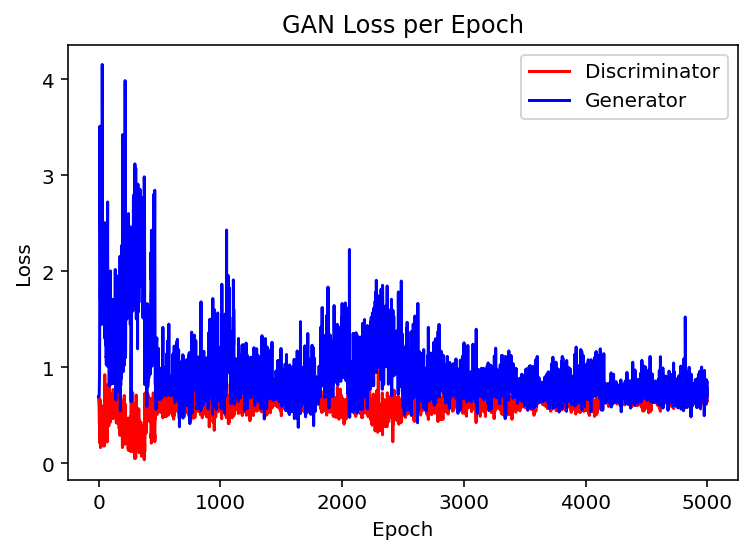

In [21]:
plt.plot(gan.disc_loss, c='red')
plt.plot(gan.gen_loss, c='blue')
plt.title("GAN Loss per Epoch")
plt.legend(['Discriminator', 'Generator'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.savefig('GAN_Loss_per_Epoch_final.png', transparent=True)
plt.show()